<a href="https://colab.research.google.com/github/gmenendez0/7506R-2C2023-GRUPO07/blob/main/7506R_TP1_GRUPO07_CHP3_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Imports y definiciones




In [ ]:
import sklearn as sk
import pandas as pd
import numpy as np
import joblib
#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score,make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV,GridSearchCV,cross_validate
#SVM
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
#xgboost
import xgboost as xgb
#ensambles hibridos
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV
#KNN
from sklearn.neighbors import KNeighborsClassifier
#RFC
!pip install 'dtreeviz'
import dtreeviz.trees as dtreeviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
def mostrar_metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

#Pre-pocesamiento

In [ ]:
# Cargamos el ds test
dsHotelTest = pd.read_csv("./hotels_test.csv")
dsHotelTestCopy = dsHotelTest.copy()

In [ ]:
dsHotelTestCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

Aplicamos tratamiento de valores faltantes con el mismo criterio del CHP1 y encodeamos columnas

In [ ]:
columnas_con_na = dsHotelTestCopy.columns[dsHotelTestCopy.isna().any()].tolist()
print("Columnas con valores faltantes:")
for columna in columnas_con_na:
    print(f"{columna}: {dsHotelTestCopy[columna].isna().sum()} valores faltantes")

Columnas con valores faltantes:
country: 95 valores faltantes
agent: 3363 valores faltantes
company: 25218 valores faltantes


In [ ]:
#AGENT
dsHotelTestCopy['agent'].fillna(-1, inplace=True)
#COUNTRY
dsHotelTestCopy['country'].fillna(dsHotelTestCopy.country.mode()[0], inplace=True)
#COMPANY
dsHotelTestCopy.drop('company', axis='columns', inplace = True)

In [ ]:
#Eliminamos columnas consideradas inusables
variables_inusables = ['id','arrival_date_week_number']
dsHotelTestCopy.drop(variables_inusables, axis='columns', inplace = True)


In [ ]:
#chequeamos nulos
dsHotelTestCopy.isna().sum()

hotel                             0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status_date     

In [ ]:
#variables_categoricas_ds_test
variables_categoricas_ds_test = dsHotelTestCopy.select_dtypes(include=['object']).columns.tolist()


In [ ]:
#VEMOS CANTIDAD DE VALORES UNICOS POR COLUMNA
dsHotelTestCopy[variables_categoricas_ds_test].nunique()

hotel                        2
arrival_date_month          12
meal                         5
country                    135
market_segment               7
distribution_channel         4
reserved_room_type          10
assigned_room_type          11
deposit_type                 3
customer_type                4
reservation_status_date    886
dtype: int64

In [ ]:
#ENCODEAMOS COUNTRY EN TOP 10 Y OTROS
dsHotelTestCopy['country_top_10_and_others'] = dsHotelTestCopy['country'].where(
dsHotelTestCopy['country'].isin(dsHotelTestCopy['country'].value_counts().nlargest(10).index), 'Others')
dsHotelTestCopy.drop('country',axis=1, inplace=True)

#convertimos arrival_date_month a int64
meses_a_numeros = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
dsHotelTestCopy['arrival_date_month'] = dsHotelTestCopy['arrival_date_month'].map(meses_a_numeros)

#eliminamos reservation_status_date @error en el ds test
dsHotelTestCopy.drop('reservation_status_date', axis='columns', inplace = True)

#agregamos high_season_moth
mediana_meses = dsHotelTestCopy['arrival_date_month'].value_counts().median()
dsHotelTestCopy['high_season_month'] = dsHotelTestCopy['arrival_date_month'].apply(lambda x: 1 if dsHotelTestCopy['arrival_date_month'].value_counts()[x] > mediana_meses else 0)


#actualizamos variables_categoricas_ds_test
variables_categoricas_ds_test = dsHotelTestCopy.select_dtypes(include=['object']).columns.tolist()


In [ ]:
#aplico one-hot (get_dummies)
dsHotelTestCopy = pd.get_dummies(dsHotelTestCopy, columns=variables_categoricas_ds_test, drop_first=True)
dsHotelTestCopy.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,country_top_10_and_others_BRA,country_top_10_and_others_DEU,country_top_10_and_others_ESP,country_top_10_and_others_FRA,country_top_10_and_others_GBR,country_top_10_and_others_IRL,country_top_10_and_others_ITA,country_top_10_and_others_Others,country_top_10_and_others_PRT,country_top_10_and_others_USA
0,277,2016,11,7,1,2,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,286,2016,5,11,0,4,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,2016,8,23,0,1,3,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,196,2016,10,29,2,5,2,2.0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,232,2016,11,26,2,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#importamos ds entrenamiento del CHP1
dsHotelCHP1=pd.read_csv('./dsHotelCHP1.csv')
ds_trabajo = dsHotelCHP1.copy()

In [ ]:
ds_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60414 entries, 0 to 60413
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           60414 non-null  object 
 1   lead_time                       60414 non-null  int64  
 2   arrival_date_year               60414 non-null  int64  
 3   arrival_date_month              60414 non-null  int64  
 4   arrival_date_day_of_month       60414 non-null  int64  
 5   stays_in_weekend_nights         60414 non-null  int64  
 6   stays_in_week_nights            60414 non-null  int64  
 7   adults                          60414 non-null  int64  
 8   children                        60414 non-null  int64  
 9   babies                          60414 non-null  int64  
 10  meal                            60414 non-null  object 
 11  country                         60414 non-null  object 
 12  market_segment                  

In [ ]:
#variables_categoricas_ds_test
variables_categoricas_ds_entrenamiento = ds_trabajo.select_dtypes(include=['object']).columns.tolist()
#VEMOS CANTIDAD DE VALORES UNICOS POR COLUMNA
ds_trabajo[variables_categoricas_ds_entrenamiento].nunique()

hotel                       2
meal                        5
country                   149
market_segment              7
distribution_channel        4
reserved_room_type          9
assigned_room_type         11
deposit_type                3
customer_type               4
id                      60414
dtype: int64

In [ ]:
#ELIMINO ID (FALTO HACERLO EN CHP1)
ds_trabajo.drop('id', axis='columns', inplace = True)

#ENCODEAMOS COUNTRY EN TOP 10 Y OTROS (harcelo en el chp1?)
ds_trabajo['country_top_10_and_others'] = ds_trabajo['country'].where(
ds_trabajo['country'].isin(ds_trabajo['country'].value_counts().nlargest(10).index), 'Others')
ds_trabajo.drop('country',axis=1, inplace=True)

#ACTUALIZO VARIABLES_CATEGORICAS_DS_ENTRENAMIENTO
variables_categoricas_ds_entrenamiento = ds_trabajo.select_dtypes(include=['object']).columns.tolist()

#LAZY, aplico one-hot al ds_test (get_dummies)
ds_trabajo = pd.get_dummies(ds_trabajo, columns=variables_categoricas_ds_test, drop_first=True)
ds_trabajo.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,country_top_10_and_others_BRA,country_top_10_and_others_DEU,country_top_10_and_others_ESP,country_top_10_and_others_FRA,country_top_10_and_others_GBR,country_top_10_and_others_IRL,country_top_10_and_others_ITA,country_top_10_and_others_Others,country_top_10_and_others_PRT,country_top_10_and_others_USA
0,49,2016,9,5,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4,2015,10,31,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,25,2016,10,13,0,1,2,2,0,0,...,0,0,0,0,0,0,0,1,0,0
3,26,2016,12,12,2,5,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,104,2017,3,19,2,5,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
#Chequeamos el ds entrenamiento y ds test
test = set(dsHotelTestCopy.columns)
entrenamiento = set(ds_trabajo.columns)

missing = list(sorted(test - entrenamiento))
added = list(sorted(entrenamiento - test))

print('Faltan en el ds entrenamiento:', missing)
print('Sobran en el ds entrenamiento:', added)

Faltan en el ds entrenamiento: ['assigned_room_type_P', 'reserved_room_type_P']
Sobran en el ds entrenamiento: ['assigned_room_type_L', 'is_canceled']


Tratamiento de valores sobrantes del ds_test

In [ ]:
#veo su frecuencia antes de hacer el one-hot con get dummies (uso el ds_test original), se podria graficar
conteo_valores = dsHotelTest['assigned_room_type'].value_counts().reset_index()
conteo_valores.columns = ['Valor', 'Conteo']
print(conteo_valores)

   Valor  Conteo
0      A   17218
1      D    5316
2      E    1576
3      F     764
4      G     517
5      C     445
6      B     439
7      H     135
8      I      66
9      K      54
10     P       5


In [ ]:
# veo muy pocos casos de assigned_room_type_P, decido movelor a la siguiente menor frecuencia, K

dsHotelTestCopy['assigned_room_type_K'] = dsHotelTestCopy['assigned_room_type_K'] + dsHotelTestCopy['assigned_room_type_P']
# Elimino 'assigned_room_type_p'
dsHotelTestCopy.drop(columns=['assigned_room_type_P'], inplace=True)

In [ ]:
conteo_valores = dsHotelTest['reserved_room_type'].value_counts().reset_index()
conteo_valores.columns = ['Valor', 'Conteo']
print(conteo_valores)

  Valor  Conteo
0     A   19366
1     D    4176
2     E    1352
3     F     630
4     G     442
5     B     241
6     C     202
7     H     118
8     P       5
9     L       3


In [ ]:
# veo muy pocos casos de reserver_room_type_P, decido mover a la menor frecuencia existente, L
dsHotelTestCopy['reserved_room_type_L'] = dsHotelTestCopy['reserved_room_type_L'] + dsHotelTestCopy['reserved_room_type_P']
# Elimino 'reserved_room_type_P'
dsHotelTestCopy.drop(columns=['reserved_room_type_P'], inplace=True)

Tratamiento valores sobrantes en el ds_entrenamiento

In [ ]:
#veo su frecuencia antes de hacer el one-hot con get dummies (uso el ds entrenamiento original), se podria graficar
conteo_valores = dsHotelCHP1['assigned_room_type'].value_counts().reset_index()
conteo_valores.columns = ['Valor', 'Conteo']
print(conteo_valores)

   Valor  Conteo
0      A   39425
1      D   11975
2      E    3681
3      F    1737
4      G    1131
5      C    1081
6      B     924
7      H     329
8      K      72
9      I      58
10     L       1


In [ ]:
# lo muevo a la siguiente menor frecuencia, I
ds_trabajo['assigned_room_type_I'] = ds_trabajo['assigned_room_type_I'] + ds_trabajo['assigned_room_type_L']
# Elimino 'assigned_room_type_L'
ds_trabajo.drop(columns=['assigned_room_type_L'], inplace=True)

In [ ]:
#Genero los conjuntos de train y de test
target = 'is_canceled'
ds_trabajo_x = ds_trabajo.drop(target, axis='columns', inplace=False)

features = ds_trabajo_x.columns.tolist()

ds_trabajo_y = ds_trabajo['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.2,
                                                    random_state=7,
                                                    stratify=ds_trabajo_y.values)

In [ ]:
#Armo una version escalada con minmax (media=0 , var=1  ) VSM
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_test_minmax  = min_max_scaler.transform(x_test)

#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

#Armo una version estandarizada del ds_test
dsHotelTestCopy_norm = stand_scaler.fit_transform(dsHotelTestCopy)

#KNN

In [ ]:
grillaDeParametros = params_grid={ 'n_neighbors':range(1,20),
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev', 'minkowski','cityblock']
             }
KNN=KNeighborsClassifier()
rand = RandomizedSearchCV(KNN, params_grid, cv=5, scoring='f1', n_iter=10, random_state=150,n_jobs = -1)

rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.71570294, 0.7377868 , 0.76650218, 0.70443259, 0.77692396,
       0.69809448, 0.71729837, 0.75908989, 0.76003889, 0.70053042])

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      5975
           1       0.77      0.80      0.79      6108

    accuracy                           0.78     12083
   macro avg       0.78      0.78      0.78     12083
weighted avg       0.78      0.78      0.78     12083



['knn.joblib']

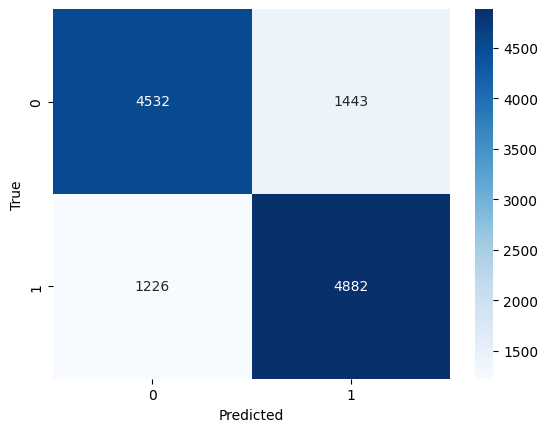

In [ ]:
#Obtenemos mejor estimador
bestKNNEnsamble=rand.best_estimator_
#Evaluo en conjunto de test y muestro matriz con metricas
y_pred = bestKNNEnsamble.predict(x_test)
f1_score(y_test, y_pred)
mostrar_metricas(y_pred,y_test)
#Exportamos modelo
joblib.dump(bestKNNEnsamble, 'knn.joblib')

In [ ]:
#Evaluo contra ds_test
yPredictedEnsamble = bestKNNEnsamble.predict(dsHotelTestCopy)
dsCHP3Sub2 = pd.DataFrame(zip(dsHotelTest['id'], yPredictedEnsamble), columns=['id', 'is_canceled'])
dsCHP3Sub2.to_csv("knn_submission.csv",index=False)

#SVM-Kernel

probamos svm por defecto con y sin aplicar escalado al set de entrenamiento (20 min)

              precision    recall  f1-score   support

           0       0.60      0.70      0.65      5975
           1       0.65      0.54      0.59      6108

    accuracy                           0.62     12083
   macro avg       0.62      0.62      0.62     12083
weighted avg       0.63      0.62      0.62     12083



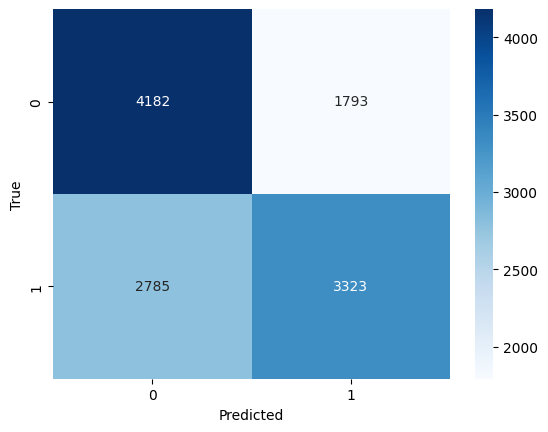

In [ ]:
#Construyo un modelo SVM
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(x_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred=svm.predict(x_test)
mostrar_metricas(y_pred,y_test)

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      5975
           1       0.85      0.85      0.85      6108

    accuracy                           0.85     12083
   macro avg       0.85      0.85      0.85     12083
weighted avg       0.85      0.85      0.85     12083



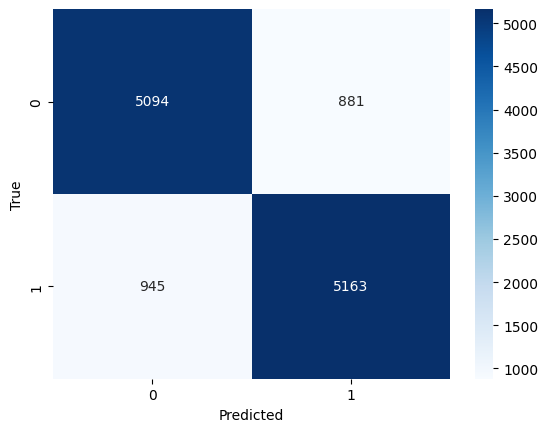

In [ ]:
#Construyo un modelo SVM con set entrenamiento normalizado
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)
mostrar_metricas(y_pred_norm,y_test)

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      5975
           1       0.83      0.85      0.84      6108

    accuracy                           0.84     12083
   macro avg       0.84      0.84      0.84     12083
weighted avg       0.84      0.84      0.84     12083



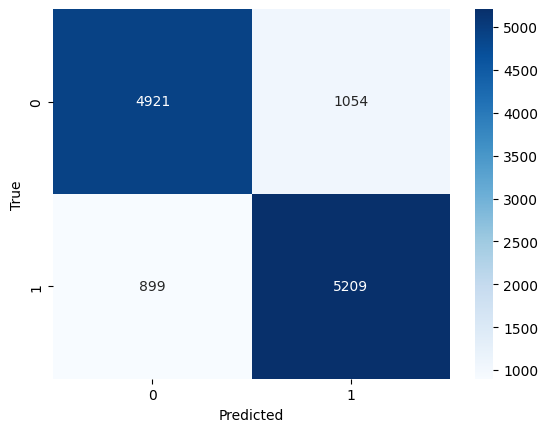

In [ ]:
#Construyo un modelo SVM  con set entrenamiento escalado min-max
svm_minmax= SVC()

#Lo entreno con los datos escalados con min max
svm_minmax.fit(x_train_minmax, y_train)

#Hago la prediccion y calculo las métricas
y_pred_minmax=svm_minmax.predict(x_test_minmax)
mostrar_metricas(y_pred_minmax,y_test)

Nos quedamos con la normalizacion estandar puesto que dio el mejor resultado

Optimizamos los 3 tipos de kernel con GridSearchCV

In [ ]:
#mostramos parametros por defecto del svc
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Lineal

In [ ]:
#Conjunto de parámetros que quiero usar
params_grid = {'C': [0.01, 0.1, 1, 5, 10, 100],
            }
#Clasificador
base_svm_lineal = LinearSVC()
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)
#GridSearch CV
gridcv_lineal = GridSearchCV(estimator = base_svm_lineal,
                      param_grid =params_grid,
                      scoring=scorer_fn,
                      n_jobs=-1
                     )

gridcv_lineal.fit(x_train_norm,y_train)

# Valores estadisticos de f1_score obtenidos
gridcv_lineal.cv_results_['mean_test_score']



array([0.79892753, 0.79938693, 0.79966062, 0.78801763, 0.77201376,
       0.71446217])

In [ ]:
print("Mostramos los mejores hiperparametros: ")
print(gridcv_lineal.best_params_)
print()
print("Mostramos el mejor")
print("f1_score = ",gridcv_lineal.best_score_)

Mostramos los mejores hiperparametros: 
{'C': 1}

Mostramos el mejor
f1_score =  0.7996606249535593


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      5975
           1       0.82      0.78      0.80      6108

    accuracy                           0.80     12083
   macro avg       0.81      0.80      0.80     12083
weighted avg       0.81      0.80      0.80     12083

Accuracy: 0.8045187453446991
Recall: 0.7814341846758349
Precision: 0.8229310344827586
f1 score: 0.8016459523009741


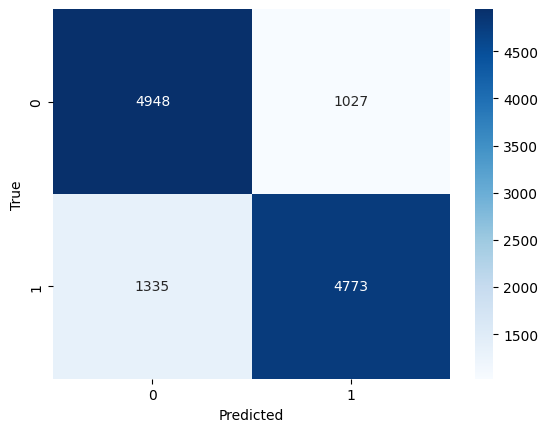

In [ ]:
#Mejor estimador
best_kernel_lineal = gridcv_lineal.best_estimator_

#Hago la prediccion y calculo las métricas
y_pred_msv_lineal = best_kernel_lineal.predict(x_test_norm)
mostrar_metricas(y_pred_msv_lineal,y_test)

accuracy=accuracy_score(y_test,y_pred_msv_lineal)
recall=recall_score(y_test,y_pred_msv_lineal)
f1=f1_score(y_test,y_pred_msv_lineal, average = 'binary')
precision=precision_score(y_test,y_pred_msv_lineal)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Del f1_score obtenido y la matriz de confusion podemos decir que el modelo generaliza bien. Sin embargo, no tenemos mejoras significativas respecto de los modelos anteriores.

In [ ]:
#Exportamos el mejor kernel_lineal
joblib.dump(best_kernel_lineal, 'kernel_lineal_optimizado.joblib')

['kernel_lineal_optimizado.joblib']

In [ ]:
#Realizamos una predicción sobre el set de test
y_pred_final_msv_lineal = best_kernel_lineal.predict(dsHotelTestCopy_norm)
#guardamos el .csv
ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred_final_msv_lineal})
ds_submission.to_csv('./msv_lineal_optimizado.csv', index=False)

Polinomico

*   No pudimos terminar de ejecutar el Random/GridSearch con este modelo, optamos por eligir la configuracion por defecto y entrenarlo con 5 folds cv.





In [ ]:
# si quieren probar correlo en sus maquinas

#Conjunto de parámetros que quiero usar
params_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10],
    'degree':[2 , 3 , 5]
}

#Clasificador
base_svm_polinomico = SVC(kernel = 'poly',cache_size=900)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)
#GridSearch CV
rcv_polinomico = RandomizedSearchCV(estimator = base_svm_polinomico,
                    param_distributions=params_grid,
                    scoring=scorer_fn,
                    n_jobs=-1,
                    random_state= 7,
                    n_iter= 5,
                    )

rcv_polinomico.fit(x_train_norm,y_train)

# Valores estadisticos de f1_score obtenidos
rcv_polinomico.cv_results_['mean_test_score']
kernel_polinomico_optimizado = rcv_polinomico.best_estimator_

In [ ]:
#Polinomico

#Clasificador
svm_poly = SVC(kernel = 'poly', cache_size=1200)

svm_poly.fit(x_train_norm,y_train)

#Cantidad de splits para el Cross Validation
kfoldcv =StratifiedKFold(n_splits=5)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)
resultados = cross_validate(svm_poly,
                                x_train_norm, y_train,
                                cv=kfoldcv,
                                scoring= scorer_fn,
                                return_estimator=True,
                            n_jobs = -1)
metricas = resultados['test_score']
kernel_polinomico_optimizado = resultados['estimator'][np.where(metricas==max(metricas))[0][0]]

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      5975
           1       0.82      0.86      0.84      6108

    accuracy                           0.83     12083
   macro avg       0.83      0.83      0.83     12083
weighted avg       0.83      0.83      0.83     12083

Accuracy: 0.8316643217743938
Recall: 0.8621480026195154
Precision: 0.8154227314958191
f1 score: 0.8381346490530002


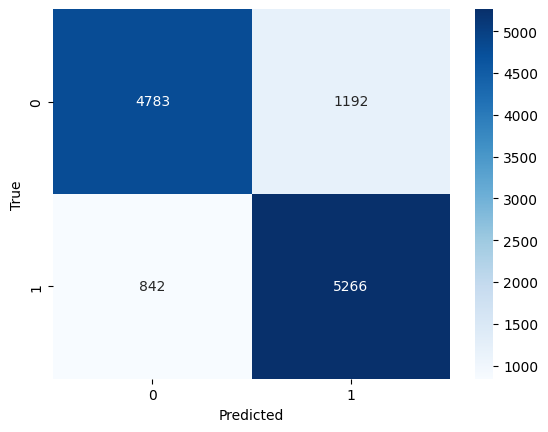

In [ ]:
#Hago la prediccion y calculo las métricas
y_pred =kernel_polinomico_optimizado.predict(x_test_norm)
mostrar_metricas(y_pred,y_test)

accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred, average='binary')
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
# exportamos el mejor
joblib.dump(kernel_polinomico_optimizado, 'best_kernel_poly.joblib')

['best_kernel_poly.joblib']

RBF

In [ ]:

#Conjunto de parámetros que quiero usar
params_grid = {'C': [ 0.01, 0.1, 1,],
               'gamma': [ 0.01, 0.1, 1,],
               'kernel':['rbf']}


#Clasificador
base_svm = SVC(cache_size=1200)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)
#GridSearch CV
gridcv_bfc = GridSearchCV(estimator = base_svm,
                      param_grid=params_grid,
                      scoring=scorer_fn,
                      n_jobs=-1
                     )

gridcv_bfc.fit(x_train_norm,y_train)

# Valores estadisticos de f1_score obtenidos
gridcv_bfc.cv_results_['mean_test_score']

array([0.74776638, 0.54066091, 0.67156836, 0.81398013, 0.77121652,
       0.48635027, 0.8351684 , 0.83846204, 0.7286107 ])

In [ ]:
print("Mostramos los mejores resultados: ")
print(gridcv_bfc.best_params_)
print()
print("Mostramos el mejor resultado obtenido de busqueda aleatoria: ")
print("f1_score = ",gridcv_bfc.best_score_)


Mostramos los mejores resultados: 
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Mostramos el mejor resultado obtenido de busqueda aleatoria: 
f1_score =  0.8384620442824767


              precision    recall  f1-score   support

           0       0.84      0.87      0.85      5975
           1       0.87      0.83      0.85      6108

    accuracy                           0.85     12083
   macro avg       0.85      0.85      0.85     12083
weighted avg       0.85      0.85      0.85     12083

Accuracy: 0.8509476123479268
Recall: 0.8348068107400131
Precision: 0.8655576302834833
f1 score: 0.84990415867989


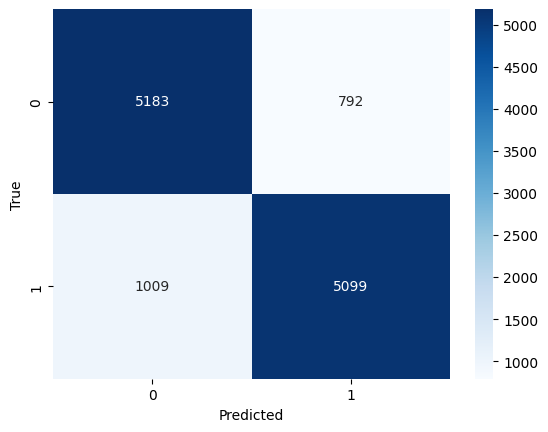

In [ ]:
# Mejor estimador rbf
best_kernel_rbf = gridcv_bfc.best_estimator_

#Hago la prediccion y calculo las métricas
y_pred =best_kernel_rbf.predict(x_test_norm)
mostrar_metricas(y_pred,y_test)

accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred, average='binary')
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Tenemos practicamente el mismo f1_score del modelo configurado por defecto. Sin embargo, este ultimo modelo se encuentra entrenado con 5 folds cv ademas, se destaca una mejora en el True negative, concluimos en utilizar este modelo para los ensambles hibridos.

In [ ]:
#exportamos el mejor
joblib.dump(best_kernel_rbf, 'best_kernel_rbf.joblib')

['best_kernel_rbf.joblib']

In [ ]:
#hacemos una prediccion contra el ds_test y guardamos la submission
y_pred_final_msv_lineal = best_kernel_rbf.predict(dsHotelTestCopy_norm)
#guardamos el .csv
ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred_final_msv_lineal})
ds_submission.to_csv('./rbf_optimizado.csv', index=False)
ds_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


#Random Forest

In [ ]:
#Creamos un clasificador con hiperparámetros arbitrarios
rfc_no_optimo = RandomForestClassifier(max_features='auto',
                             criterion="entropy",
                             min_samples_leaf=5,
                             min_samples_split=5,
                             n_estimators=30,
                              random_state=7,
                             n_jobs=-1,)
#Entrenamos el modelo
model = rfc_no_optimo.fit(X = x_train, y = y_train)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5975
           1       0.88      0.87      0.88      6108

    accuracy                           0.88     12083
   macro avg       0.88      0.88      0.88     12083
weighted avg       0.88      0.88      0.88     12083

Accuracy: 0.8766034925101382
Recall: 0.8700065487884742
Precision: 0.8840459158209948
f1 score: 0.8769700470335837


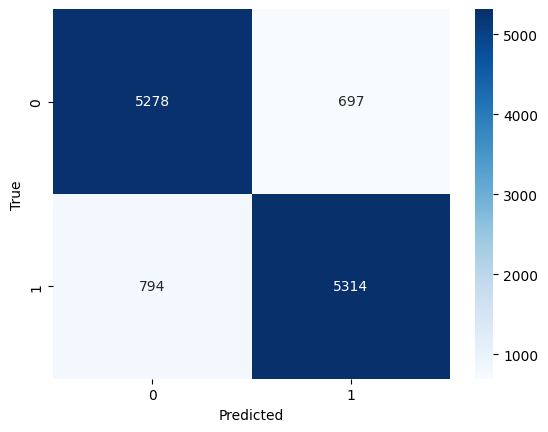

In [ ]:
#Realizamos una predicción sobre el set de test
y_pred_rfc_no_optimo = model.predict(x_test)
#grafico matriz de confusion y metricas
mostrar_metricas(y_pred_rfc_no_optimo,y_test)

accuracy=accuracy_score(y_test, y_pred_rfc_no_optimo)
recall=recall_score(y_test, y_pred_rfc_no_optimo)
f1=f1_score(y_test, y_pred_rfc_no_optimo, average='binary')
precision=precision_score(y_test,y_pred_rfc_no_optimo)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))


In [ ]:
#Exportamos
joblib.dump(rfc_no_optimo, 'rfc_no_optimizado.joblib')

['rfc_no_optimizado.joblib']

In [ ]:
#top 10 features mas importantes
p = sorted(list(zip(ds_trabajo_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])
for i in range(10):
    print(p[i])

('deposit_type_Non Refund', 0.14822321905075508)
('lead_time', 0.10897361477638388)
('country_top_10_and_others_PRT', 0.09539819039329676)
('total_of_special_requests', 0.06020327182492513)
('agent', 0.05932621662795421)
('required_car_parking_spaces', 0.04772139647380853)
('adr', 0.04633339484789843)
('previous_cancellations', 0.03903938084367643)
('market_segment_Online TA', 0.03774938819561058)
('arrival_date_day_of_month', 0.028010531783929815)


In [ ]:
#pruebo contra el ds test y lo exporto
y_pred = model.predict(dsHotelTestCopy)
ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred})
ds_submission.to_csv('./rfc_no_optimizado.csv', index=False)

Optimizamos hiperparametros con GridSearch CV

In [ ]:
rf_cv = RandomForestClassifier(max_features='auto', random_state=7, n_jobs=-1)
kfoldcv = StratifiedKFold(n_splits=10)
scorer_fn = make_scorer(f1_score)
param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 2, 5, 7, 10],
               "min_samples_split" : [2, 4, 10, 15, 20],
               "n_estimators": [ 20, 30, 40, 50, 60, 70] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv,
                  param_grid=param_grid,
                  scoring = scorer_fn,
                  cv=kfoldcv,
                  n_jobs=-1)
gs_fit = gs.fit(X = x_train, y = y_train)

In [ ]:
#mostramos la mejor config de hiperparametros
gs_fit.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 70}

In [ ]:
#el mejor f1_score
print("f1_score en entrenamiento con cv: "+str(gs_fit.best_score_))

f1_score en entrenamiento con cv: 0.8795456549258531


              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5975
           1       0.89      0.88      0.89      6108

    accuracy                           0.89     12083
   macro avg       0.89      0.89      0.89     12083
weighted avg       0.89      0.89      0.89     12083

Accuracy: 0.8869486054787719
Recall: 0.8808120497707924
Precision: 0.8939847125290794
f1 score: 0.8873494969487052


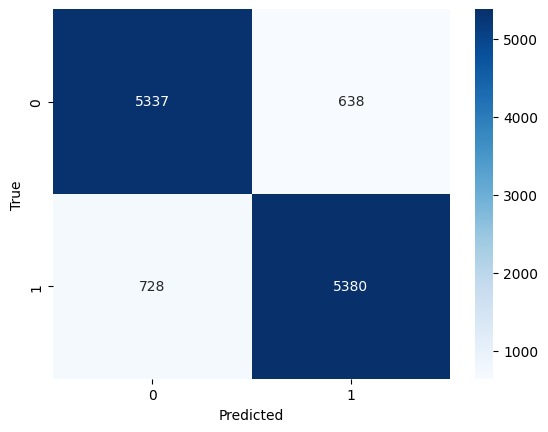

In [ ]:
#Obtenemos el mejor modelo
rf_cv_best = gs_fit.best_estimator_
#exportamos
joblib.dump( rf_cv_best, 'random_forest_optimizado_f1_score.joblib')
#Predicción grafico y metricas
y_pred_rf_cv_best = rf_cv_best.predict(x_test)

mostrar_metricas(y_pred_rf_cv_best,y_test)

accuracy_unimetrica=accuracy_score(y_test,y_pred_rf_cv_best)
recall_unimetrica=recall_score(y_test,y_pred_rf_cv_best)
f1_unimetrica=f1_score(y_test,y_pred_rf_cv_best, average='binary')
precision_unimetrica=precision_score(y_test,y_pred_rf_cv_best)

print("Accuracy: "+str(accuracy_unimetrica))
print("Recall: "+str(recall_unimetrica))
print("Precision: "+str(precision_unimetrica))
print("f1 score: "+str(f1_unimetrica))

In [ ]:
#prediccion contra el ds_test y guardamos submission
y_pred = rf_cv_best.predict(dsHotelTestCopy)
ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred})
ds_submission.to_csv('./rfc_optimizado_f1_score_10_folds.csv', index=False)
ds_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


Optimizar hiperparámetros considerando mas de una métrica

In [ ]:
rf_cv = RandomForestClassifier(max_features='auto', random_state=7, n_jobs=-1)
kfoldcv = StratifiedKFold(n_splits=10)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 2, 5, 7, 10],
               "min_samples_split" : [2, 4, 10, 15, 20],
               "n_estimators": [ 20, 30, 40, 50, 60, 70] }
#Probamos entrenando con varias métricas

metricas=['accuracy','f1','roc_auc' ,'recall', 'precision']

gs_multimetrica = GridSearchCV(estimator=rf_cv,
                               param_grid=param_grid,
                               scoring=metricas,
                               refit=False,
                               cv=kfoldcv,
                               n_jobs=-1,)
#Entrenamiento
gs_multimetrica_fit = gs_multimetrica.fit(X = x_train, y = y_train)

Graficamos los resultados de las métricas

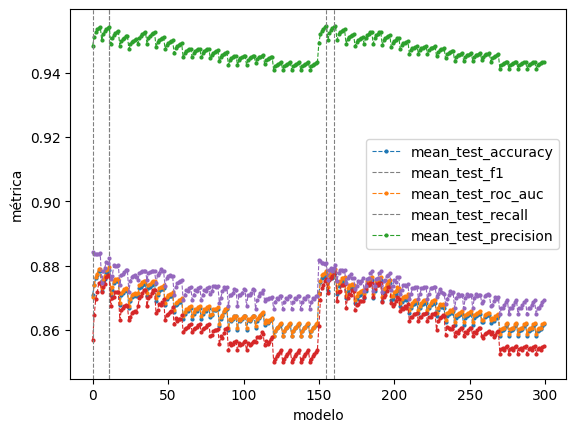

In [ ]:
labels=[ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)
    x_linea=np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')

plt.xlabel("modelo", fontsize=10)
plt.ylabel("métrica", fontsize=10)
plt.legend(labels)
plt.show()

In [ ]:
for metrica in metricas:
    mejores_params =gs_multimetrica_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_' + metrica])]
    print(metrica + ": " + str(mejores_params))

accuracy: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
f1: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
roc_auc: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
recall: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
precision: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}


In [ ]:
#Creamos un clasificador RF
params_elegidos=gs_multimetrica_fit.cv_results_['params'][161]#np.argmax(gs_multimetrica_fit.cv_results_['mean_test_f1'])]
rfc_multimetrica = RandomForestClassifier(criterion= params_elegidos['criterion'],
                                          min_samples_leaf= params_elegidos['min_samples_leaf'],
                                          min_samples_split= params_elegidos['min_samples_split'],
                                          n_estimators=params_elegidos['n_estimators'],
                                          oob_score=True, random_state=7, n_jobs=-1)
#Entrenamos un modelo
model_rfc_multimetrica = rfc_multimetrica.fit(X = x_train, y = y_train)


              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5975
           1       0.90      0.89      0.89      6108

    accuracy                           0.89     12083
   macro avg       0.89      0.89      0.89     12083
weighted avg       0.89      0.89      0.89     12083

Accuracy: 0.8898452371099892
Recall: 0.8857236411263916
Precision: 0.8952507032930663
f1 score: 0.8904616903958521


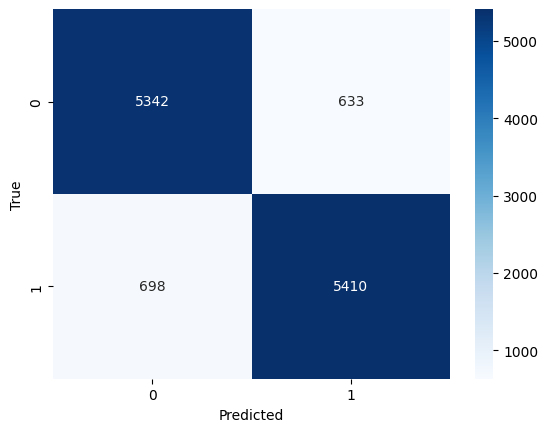

In [ ]:
#Hacemos una predicción contra el set de prueba
y_pred_model_rfc_multimetrica = model_rfc_multimetrica.predict(x_test)
#graficamos matriz confusion y calculamos metricas
mostrar_metricas(y_pred_model_rfc_multimetrica,y_test)
accuracy_multi_metrica = accuracy_score(y_test,y_pred_model_rfc_multimetrica)
recall_multi_metrica = recall_score(y_test,y_pred_model_rfc_multimetrica)
f1_multi_metrica = f1_score(y_test,y_pred_model_rfc_multimetrica, average='binary')
precision_multi_metrica = precision_score(y_test,y_pred_model_rfc_multimetrica)

print("Accuracy: "+str(accuracy_multi_metrica))
print("Recall: "+str(recall_multi_metrica))
print("Precision: "+str(precision_multi_metrica))
print("f1 score: "+str(f1_multi_metrica))

In [ ]:
#exportamos el modelo
joblib.dump(model_rfc_multimetrica, 'rfc_optimizado_multi_metrica_10_f.joblib')

['rfc_optimizado_multi_metrica_10_f.joblib']

In [ ]:
#prediccion contra el ds_test y guardamos submission
y_pred = model_rfc_multimetrica.predict(dsHotelTestCopy)
ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred})
ds_submission.to_csv('./rfc_multi_10folds.csv', index=False)
ds_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


obtuvimos practicamente el mismo rendimiento

#XGBoost

Training

In [ ]:
#Creo un clasificador
xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)

#Entreno el modelo
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Primer predict con un modelo no optimizado

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5975
           1       0.87      0.88      0.88      6108

    accuracy                           0.88     12083
   macro avg       0.88      0.88      0.88     12083
weighted avg       0.88      0.88      0.88     12083



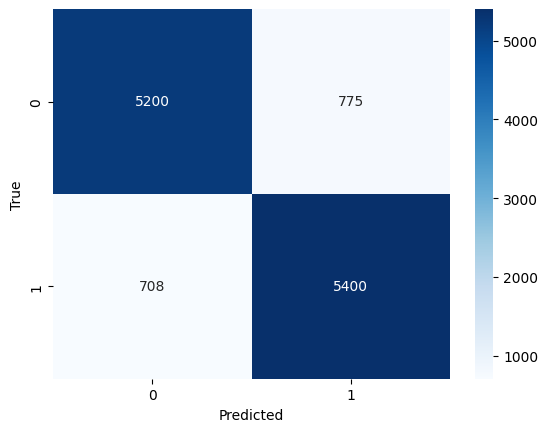

In [ ]:
#Matriz de Confusion
y_pred = xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))

Optimizacion de hiperparametros  Con random_search

Busqueda de mejor modelo

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [ ]:
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid,
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=-1,
                                   scoring='accuracy')
random_search.fit(x_train, y_train)
best_params = random_search.best_params_

Entrenamiento del mejor modelo

In [ ]:
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Evaluacion del mejor modelo

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5975
           1       0.88      0.88      0.88      6108

    accuracy                           0.88     12083
   macro avg       0.88      0.88      0.88     12083
weighted avg       0.88      0.88      0.88     12083



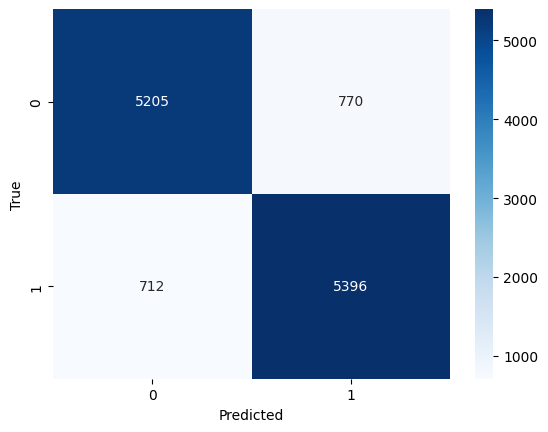

In [ ]:
y_pred = best_xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))

Busqueda de mejor modelo Con grid_search

In [ ]:
grid_search = GridSearchCV(estimator = xgb.XGBClassifier(random_state=7), param_grid = param_grid
                           , cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

Entrenamiento del modelo

In [ ]:
#Obtenemos el mejor modelo
best_xgb_model = grid_search.best_estimator_


 Evaluacion del mejor modelo

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5975
           1       0.88      0.88      0.88      6108

    accuracy                           0.88     12083
   macro avg       0.88      0.88      0.88     12083
weighted avg       0.88      0.88      0.88     12083



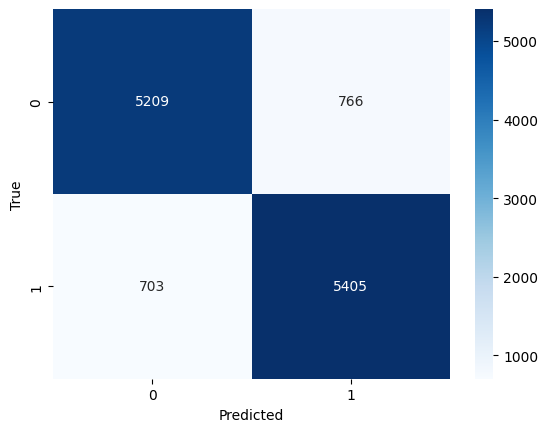

In [ ]:
y_pred = best_xgb_model.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))

Realizar prediccion final

In [ ]:
#evaluamos contra ds_test
y_pred_final = best_xgb_model.predict(dsHotelTestCopy)

ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred_final})
ds_submission.to_csv('./xgboost_submission.csv', index=False)
#Exportamos modelo
joblib.dump(best_xgb_model, 'XGBoost.joblib')

['XGBoost.joblib']

# Voting


              precision    recall  f1-score   support

           0       0.79      0.94      0.86      5975
           1       0.93      0.76      0.83      6108

    accuracy                           0.85     12083
   macro avg       0.86      0.85      0.85     12083
weighted avg       0.86      0.85      0.85     12083



['voting.joblib']

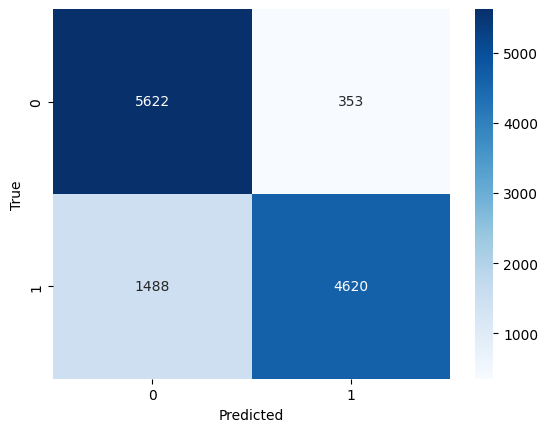

In [ ]:
#importamos los modelos entrenados

knn_clf = joblib.load('knn.joblib')
svm_clf =  joblib.load('rbf.joblib')
rf_clf = joblib.load('rfc_multi_10.joblib')
xgb_clf = joblib.load('XGBoost.joblib')

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('knn', knn_clf),
                                          ('rf', rf_clf),
                                          ('xgb', xgb_clf),
                                          ('svm',svm_clf)],
                                          voting = 'hard',
                                          #soft,
                                          n_jobs=-1,)

#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test y muestro matriz con metricas
y_pred = vot_clf.predict(x_test)
f1_score(y_test, y_pred)
mostrar_metricas(y_pred,y_test)
joblib.dump(vot_clf, 'voting.joblib')


In [ ]:
#prediccion contra el ds_test y guardamos submission
y_pred = vot_clf.predict(dsHotelTestCopy)
ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred})
ds_submission.to_csv('./voting.csv', index=False)
ds_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


#Stacking

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5975
           1       0.89      0.88      0.89      6108

    accuracy                           0.89     12083
   macro avg       0.89      0.89      0.89     12083
weighted avg       0.89      0.89      0.89     12083



['stacking.joblib']

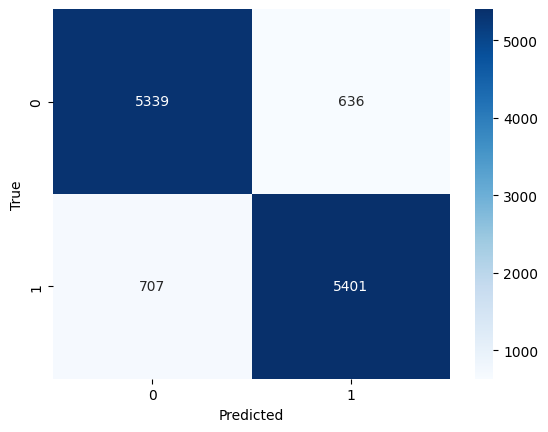

In [ ]:
#Modelos Base
base_models = [('knn', knn_clf),
                ('rf', rf_clf),
                ('xgb', xgb_clf),
                ('svm',svm_clf)]
#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)
#Entrenamos Stacking
stacking_model.fit(x_train,y_train)

#Evaluo en conjunto de test y muestro matriz con metricas
y_pred = stacking_model.predict(x_test)
f1_score(y_test, y_pred)
mostrar_metricas(y_pred,y_test)
joblib.dump(stacking_model, 'stacking.joblib')

In [ ]:
#prediccion contra el ds_test y guardamos submission
y_pred = stacking_model.predict(dsHotelTestCopy)
ds_submission = pd.DataFrame({'id': dsHotelTest['id'], 'is_canceled': y_pred})
ds_submission.to_csv('./stacking.csv', index=False)
ds_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
